In [19]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("harshsaini105/shl-data")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'shl-data' dataset.
Path to dataset files: /kaggle/input/shl-data


In [ ]:
import shutil

# Folder where KaggleHub saved your dataset
src = "/root/.cache/kagglehub/datasets/harshsaini105/shl-data/versions/1"

# Compress it into a single zip file
shutil.make_archive("/content/shl-data", "zip", src)



'/content/shl-data.zip'

In [ ]:
from google.colab import files
files.download("/content/shl-data.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /root/.cache/kagglehub/datasets/harshsaini105/shl-data/versions/1 /content/drive/MyDrive/shl-data


Mounted at /content/drive


In [28]:
pip install torch torchaudio librosa transformers sentence-transformers tqdm scikit-learn xgboost joblib


In [29]:
import os
import numpy as np
import pandas as pd
import librosa
import torch
from tqdm import tqdm
from transformers import WhisperProcessor, WhisperModel
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
import joblib


In [30]:
CSV_PATH = "/root/.cache/kagglehub/datasets/harshsaini105/shl-data/versions/1/dataset/train.csv"
AUDIO_DIR = "/root/.cache/kagglehub/datasets/harshsaini105/shl-data/versions/1/dataset/audios_train"

df = pd.read_csv(CSV_PATH)
print("✅ CSV loaded successfully!")
print("Rows:", len(df))
print(df.head())

valid = df["filename"].apply(lambda f: os.path.exists(os.path.join(AUDIO_DIR, f)))
print("\n🎵 Valid audio files found:", valid.sum(), "/", len(df))



✅ CSV loaded successfully!
Rows: 444
         filename  label
0  audio_1261.wav    1.0
1   audio_942.wav    1.5
2  audio_1110.wav    1.5
3  audio_1024.wav    1.5
4   audio_538.wav    2.0

🎵 Valid audio files found: 444 / 444


In [32]:
def extract_audio_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)

        if len(y) < 10:  # too short or broken audio
            return np.zeros(32)

        # MFCCs
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = mfcc.mean(axis=1)
        mfcc_std = mfcc.std(axis=1)

        # Spectral features
        zcr = np.mean(librosa.feature.zero_crossing_rate(y))
        centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
        rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
        rms = np.mean(librosa.feature.rms(y=y))

        features = np.hstack([mfcc_mean, mfcc_std, [zcr, centroid, bandwidth, rolloff, rms]])
        return features

    except Exception as e:
        print(f"Librosa error in {file_path}: {e}")
        return np.zeros(32)


In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = WhisperProcessor.from_pretrained("openai/whisper-small")
hf_whisper = WhisperModel.from_pretrained("openai/whisper-small").to(device)

def extract_whisper_features(file_path):
    try:
        audio, sr = librosa.load(file_path, sr=16000)
        inputs = processor(audio, sampling_rate=16000, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = hf_whisper.encoder(**inputs)
            embedding = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

        text = "placeholder"  # Optional placeholder text
        return text, embedding
    except Exception as e:
        print(f"Whisper error in {file_path}: {e}")
        return "", np.zeros(768)


preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

In [34]:
text_model = SentenceTransformer("all-MiniLM-L6-v2")

def text_to_embedding(text):
    try:
        if not text or len(text.strip()) == 0:
            text = "empty"
        return text_model.encode(text)
    except Exception as e:
        print(f"Text embedding error: {e}")
        return np.zeros(384)


In [35]:
librosa_feats = []
labels = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    file_path = os.path.join(AUDIO_DIR, row["filename"])

    # A. Librosa (acoustic)
    librosa_vec = extract_audio_features(file_path)

    # B. Whisper (audio semantics)
    text, whisper_vec = extract_whisper_features(file_path)

    # C. SentenceTransformer (text meaning)
    text_vec = text_to_embedding(text)

    # D. Combine all
    try:
        hybrid_vec = np.concatenate([librosa_vec, whisper_vec, text_vec])
        librosa_feats.append(hybrid_vec)
        labels.append(row["label"])
    except Exception as e:
        print(f"Concat error in {row['filename']}: {e}")
        continue

X_hybrid = np.array(librosa_feats)
y_hybrid = np.array(labels)

print("✅ Hybrid feature matrix shape:", X_hybrid.shape)


100%|██████████| 444/444 [03:47<00:00,  1.95it/s]

✅ Hybrid feature matrix shape: (444, 1183)


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(X_hybrid, y_hybrid, test_size=0.3, random_state=42)

# XGBoost model
model = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

model.fit(X_train, y_train)
y_pred = model.predict(X_val)

# Evaluate
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f"✅ Model trained successfully!\nMAE: {mae:.4f}\nR² Score: {r2:.4f}")


✅ Model trained successfully!
MAE: 0.6363
R² Score: 0.5584


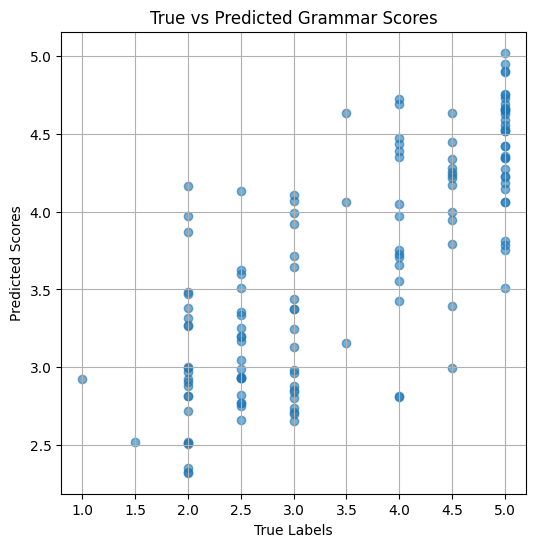

📈 Pearson Correlation: 0.7746


In [37]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred, alpha=0.6)
plt.xlabel("True Labels")
plt.ylabel("Predicted Scores")
plt.title("True vs Predicted Grammar Scores")
plt.grid(True)
plt.show()

# Pearson correlation
pearson_corr, _ = pearsonr(y_val, y_pred)
print(f"📈 Pearson Correlation: {pearson_corr:.4f}")


In [43]:
import joblib
joblib.dump(model, "xgb_hybrid_model.pkl")
np.save("X_hybrid.npy", X_hybrid)
np.save("y_hybrid.npy", y_hybrid)
print("💾 Saved model and features successfully!")


💾 Saved model and features successfully!


📈 Pearson Correlation: 0.7746


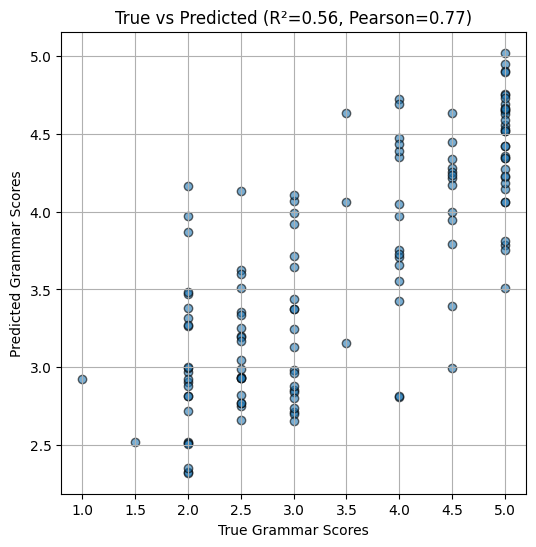

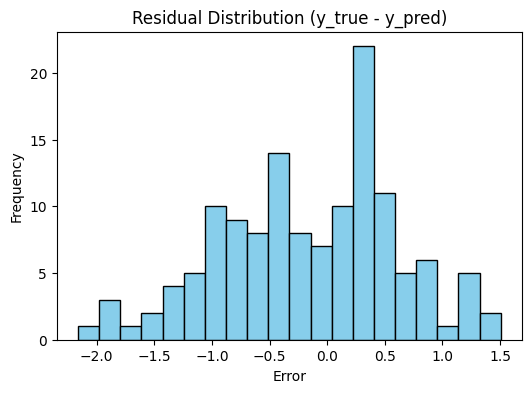

In [39]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Compute Pearson correlation
pearson_corr, _ = pearsonr(y_val, y_pred)
print(f"📈 Pearson Correlation: {pearson_corr:.4f}")

# Scatter plot
plt.figure(figsize=(6,6))
plt.scatter(y_val, y_pred, alpha=0.6, edgecolors='k')
plt.xlabel("True Grammar Scores")
plt.ylabel("Predicted Grammar Scores")
plt.title(f"True vs Predicted (R²={r2:.2f}, Pearson={pearson_corr:.2f})")
plt.grid(True)
plt.show()

# Residual analysis
residuals = y_val - y_pred
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=20, color="skyblue", edgecolor="black")
plt.title("Residual Distribution (y_true - y_pred)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()


In [41]:
# Split your dataset manually for testing the submission pipeline
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_hybrid, y_hybrid, test_size=0.3, random_state=42)

# Generate predictions for the "test" part
preds = model.predict(X_test)

# Create submission DataFrame
submission = pd.DataFrame({
    "filename": test_df["filename"].values,
    "label": preds
})

submission.to_csv("submission.csv", index=False)
print("✅ submission.csv created successfully!")
print(submission.head())


✅ submission.csv created successfully!
        filename     label
0  audio_450.wav  4.277181
1  audio_809.wav  3.376591
2  audio_913.wav  2.662503
3  audio_396.wav  4.653279
4  audio_399.wav  2.970142


In [44]:
print(type(X_hybrid))
print(np.shape(X_hybrid))
print(np.shape(y_hybrid))
print(df.head())


<class 'numpy.ndarray'>
(444, 1183)
(444,)
         filename  label
0  audio_1261.wav    1.0
1   audio_942.wav    1.5
2  audio_1110.wav    1.5
3  audio_1024.wav    1.5
4   audio_538.wav    2.0


**Save Precomputed Features for Fast Deployment**


In [46]:
np.save("X_hybrid.npy", X_hybrid)
np.save("y_hybrid.npy", y_hybrid)
np.save("filenames.npy", df['filename'].values)
print("✅ Saved precomputed features. Check file sizes below:")
!ls -lh utils/


✅ Saved precomputed features. Check file sizes below:
ls: cannot access 'utils/': No such file or directory


In [47]:
import os, shutil

os.makedirs("utils", exist_ok=True)
for f in ["X_hybrid.npy", "y_hybrid.npy", "filenames.npy"]:
    if os.path.exists(f):
        shutil.move(f, os.path.join("utils", f))

!ls -lh utils/


total 4.1M
-rw-r--r-- 1 root root 7.3K Nov  7 10:52 filenames.npy
-rw-r--r-- 1 root root 4.1M Nov  7 10:52 X_hybrid.npy
-rw-r--r-- 1 root root 3.6K Nov  7 10:52 y_hybrid.npy


In [48]:
X = np.load("utils/X_hybrid.npy")
y = np.load("utils/y_hybrid.npy")
print(X.shape, y.shape)


(444, 1183) (444,)
